<a href="https://colab.research.google.com/github/rasoco/master_data_science/blob/master/Big%20Data/%20Clase%204/%2004_ML_in_Spark_workingme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tuning Machine Learning models in Spark

<a href = "http://yogen.io"><img src="http://yogen.io/assets/logo.svg" alt="yogen" style="width: 200px; float: right;"/></a>

### If you are running this notebook in Google Colab

Copy the following to a code cell and run it. It will install and set up Spark for you.

```python
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.uvigo.es/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
!tar -xf spark-2.4.6-bin-hadoop2.7.tgz
!pip install -q findspark

import os
import findspark
from pyspark.sql import SparkSession

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()
```

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.uvigo.es/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
!tar -xf spark-2.4.6-bin-hadoop2.7.tgz
!pip install -q findspark pyspark==2.4.6
 
import os
import findspark
from pyspark.sql import SparkSession
 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

     |████████████████████████████████| 218.4MB 61kB/s 
     |████████████████████████████████| 204kB 45.7MB/s 


##Conecting with drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = spark.read.csv('/content/drive/My Drive/BigData Spark/Clase 1/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv.gz', header=True, inferSchema=True)

## ML Pipelines in Spark

ML model training and tuning often represents running the same steps once and again. Often, we run the same steps with small variations in order to evaluate combinations of parameters. 

In order to make this use case a lot easier, Spark provides the [Pipeline](https://spark.apache.org/docs/2.3.0/ml-pipeline.html) abstraction.

A Pipeline represents a series of steps in the processing of a dataset. Each step is a Transformer or an Estimator. The whole Pipeline is an Estimator, so we can .fit the whole pipeline in one step. When we do that, the steps'  .fit and .transform methods will be called in turn.

![pipelineestimator](https://spark.apache.org/docs/2.3.0/img/ml-Pipeline.png)

![PipelineModel](https://spark.apache.org/docs/2.3.0/img/ml-PipelineModel.png)

## Example: predicting flight delays

We'll be using the same [Transtats'](https://www.transtats.bts.gov/) OTP performance data] from way back when. Remember it?

It's a table that contains all domestic departures by US air air carriers that represent at least one percent of domestic scheduled passenger revenues, with data on each individual departure including [Tail Number](https://en.wikipedia.org/wiki/Tail_number), departure delay, origin, destination and carrier.


### Load the data

Opening .zip files in Spark is a bit of a pain. For now, let's just decompress the file we want to read. When we are ready to expand the processing to the cluster, we will need to do [this](https://stackoverflow.com/questions/28569788/how-to-open-stream-zip-files-through-spark).

```python
csvname = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv'
columns_of_interest = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 
                       'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                       'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                       'DepTime', 'DepDelay', 'AirTime', 'Distance']
```

In [ ]:
csvname = '/content/drive/My Drive/BigData Spark/Clase 1/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv'
columns_of_interest = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 
                       'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                       'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                       'DepTime', 'DepDelay', 'AirTime', 'Distance']

In [ ]:
ls -lrt

total 227764
drwxr-xr-x 13 1000 1000      4096 May 30 00:02 spark-2.4.6-bin-hadoop2.7/
-rw-r--r--  1 root root 233215067 May 30 00:54 spark-2.4.6-bin-hadoop2.7.tgz
drwxr-xr-x  1 root root      4096 Jun 26 16:26 sample_data/
drwx------  4 root root      4096 Jul 10 18:07 drive/


In [ ]:
from pyspark.sql import SparkSession
csvname = '/content/drive/My Drive/BigData Spark/Clase 1/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv'
columns_of_interest = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 
                       'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                       'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                       'DepTime', 'DepDelay', 'AirTime', 'Distance']
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv('/content/drive/My Drive/BigData Spark/Clase 1/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv.gz', header=True, inferSchema=True)     
df.printSchema()
    

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: timestamp (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- DOT_ID_Reporting_Airline: integer (nullable = true)
 |-- IATA_CODE_Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- OriginAirportSeqID: integer (nullable = true)
 |-- OriginCityMarketID: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- OriginStateFips: integer (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- OriginWac: integer (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DestAirportSe

In [ ]:
flights = df.select(columns_of_interest) #save this columns 
flights.printSchema() # devuelve columnas, l tipo de columna y si puede estar vacío o no


root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)



### Drop nas

There are only a few departures for which any of the columns of interest contains null values. The most expedient way to handle them is to just drop them, since they won't make much of a difference.

In [ ]:
flights.summary().show() #crear un dataframe

+-------+------+------+------------------+-----------------+-----------------+-----------+-------------------------------+------+--------------+---------------+------+------------+-------------+------------------+-----------------+------------------+-----------------+
|summary|  Year| Month|        DayofMonth|        DayOfWeek|Reporting_Airline|Tail_Number|Flight_Number_Reporting_Airline|Origin|OriginCityName|OriginStateName|  Dest|DestCityName|DestStateName|           DepTime|         DepDelay|           AirTime|         Distance|
+-------+------+------+------------------+-----------------+-----------------+-----------+-------------------------------+------+--------------+---------------+------+------------+-------------+------------------+-----------------+------------------+-----------------+
|  count|593842|593842|            593842|           593842|           593842|     592744|                         593842|593842|        593842|         593842|593842|      593842|       593842

In [ ]:
flights.count()

593842

In [ ]:
from pyspark.sql import functions, types #para que me diga el numero de nulls

flights.select(
    
)

NA-related functions are grouped in a .na attribute of DataFrames.

In [ ]:
flights.na

In [ ]:
flights2 = flights.na.drop() #siempre guardar no sobreescribir variables, los objetos son inmutables, eliminamos los blancos

flights2.summary().show(10)

+-------+------+------+------------------+------------------+-----------------+-----------+-------------------------------+------+--------------+---------------+------+------------+-------------+-----------------+------------------+------------------+-----------------+
|summary|  Year| Month|        DayofMonth|         DayOfWeek|Reporting_Airline|Tail_Number|Flight_Number_Reporting_Airline|Origin|OriginCityName|OriginStateName|  Dest|DestCityName|DestStateName|          DepTime|          DepDelay|           AirTime|         Distance|
+-------+------+------+------------------+------------------+-----------------+-----------+-------------------------------+------+--------------+---------------+------+------------+-------------+-----------------+------------------+------------------+-----------------+
|  count|585737|585737|            585737|            585737|           585737|     585737|                         585737|585737|        585737|         585737|585737|      585737|       58

In [ ]:
flights2.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)



## Feature extraction and generation of target variable

The departing hour is the most important factor in delays, so we need to calculate it from the departure time. Since the input file uses a funny format for times, Spark has interpreted them as floats:

Model Machine Learning: sacer las features para entrenar y variable objetivo.

ML: Hacer un modelo para predicir si un vuelo recibirá retraso o no Problema Clasificación. 

Transformacion mi target DepTime a categorica. 
Feature: DepHour.

In [ ]:
flights2.select('DepTime').show(5) #es una variable númerica, cambiarla de númerica a categorica poniendo un umbral a partir de 15 minutos es retraso.

+-------+
|DepTime|
+-------+
|   1048|
|    638|
|   1710|
|   1318|
|    953|
+-------+
only showing top 5 rows



#### Exercise

Calculated the 'DepHour' column that represents the hour as an int.

In [ ]:
from pyspark.sql import types
flights3 = flights2.withColumn('DepHour', (flights2['DepTime'] / 100).cast(types.IntegerType()))

In [ ]:
flights3.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DepHour: integer (nullable = true)



In [ ]:
% time
fligths3.show(10)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
+----+-----+----------+---------+-----------------+-----------+-------------------------------+------+--------------+---------------+----+----------------+-------------+-------+--------+-------+--------+----+
|Year|Month|DayofMonth|DayOfWeek|Reporting_Airline|Tail_Number|Flight_Number_Reporting_Airline|Origin|OriginCityName|OriginStateName|Dest|    DestCityName|DestStateName|DepTime|DepDelay|AirTime|Distance|Hour|
+----+-----+----------+---------+-----------------+-----------+-------------------------------+------+--------------+---------------+----+----------------+-------------+-------+--------+-------+--------+----+
|2018|   12|        25|        2|               WN|     N566WN|                           1823|   OAK|   Oakland, CA|     California| GEG|     Spokane, WA|   Washington|   1048|    18.0|  111.0|   723.0|  10|
|2018|   12|        25|        2|               WN|     N562WN|                            982|   OA

Crear una función para quitar los ultimos caracteres

In [ ]:
str(num)[:-2]
from pyspark.sql import functions, types
time = 1034
def strHour(time):
  return int(str(time)[:-2])
strHour(time)

In [ ]:
from pyspark.sql import functions, types

In [ ]:
takeHour_udf = functions.udf(lambda time:int(str(time)[:-2]), returnType=types.IntegerType()) #no me hace falta la funcion, creo una lambda 

In [ ]:
flights3b= flights2.withColumn("DepHour", takeHour_udf("DepTime").cast(types.IntegerType()))

NameError: ignored

In [ ]:
flights3b.show(5)

+----+-----+----------+---------+-----------------+-----------+-------------------------------+------+--------------+---------------+----+------------+-------------+-------+--------+-------+--------+-------+
|Year|Month|DayofMonth|DayOfWeek|Reporting_Airline|Tail_Number|Flight_Number_Reporting_Airline|Origin|OriginCityName|OriginStateName|Dest|DestCityName|DestStateName|DepTime|DepDelay|AirTime|Distance|DepHour|
+----+-----+----------+---------+-----------------+-----------+-------------------------------+------+--------------+---------------+----+------------+-------------+-------+--------+-------+--------+-------+
|2018|   12|        25|        2|               WN|     N566WN|                           1823|   OAK|   Oakland, CA|     California| GEG| Spokane, WA|   Washington|   1048|    18.0|  111.0|   723.0|     10|
|2018|   12|        25|        2|               WN|     N562WN|                            982|   OAK|   Oakland, CA|     California| HOU| Houston, TX|        Texas|   

We will also generate a binary target variable. The aviation industry considers a flight delayed when it departs more than 15 minutes after its scheduled departure time, so we will use that. We will create it as an integer, since that is what the learning algorithms expect.

delayed mayor 15 minutos 1

delayed menor 15 minutos 0

In [ ]:
flights4 = flights3.withColumn('Delayed', (flights3['DepDelay'] > 15).cast(types.IntegerType())) #más de 15 minutos 1

In [ ]:
flights4.show(5)

+----+-----+----------+---------+-----------------+-----------+-------------------------------+------+--------------+---------------+----+------------+-------------+-------+--------+-------+--------+-------+-------+
|Year|Month|DayofMonth|DayOfWeek|Reporting_Airline|Tail_Number|Flight_Number_Reporting_Airline|Origin|OriginCityName|OriginStateName|Dest|DestCityName|DestStateName|DepTime|DepDelay|AirTime|Distance|DepHour|Delayed|
+----+-----+----------+---------+-----------------+-----------+-------------------------------+------+--------------+---------------+----+------------+-------------+-------+--------+-------+--------+-------+-------+
|2018|   12|        25|        2|               WN|     N566WN|                           1823|   OAK|   Oakland, CA|     California| GEG| Spokane, WA|   Washington|   1048|    18.0|  111.0|   723.0|     10|      1|
|2018|   12|        25|        2|               WN|     N562WN|                            982|   OAK|   Oakland, CA|     California| HO

In order to make the training times manageable, let's pick only 10% of the data to train.

In [ ]:
train, rest = flights4.randomSplit([0.1, 0.9]) #10% train, 90 test, lo hacemos así porque tarda mucho en correr

In [ ]:
train.show(10)

+----+-----+----------+---------+-----------------+-----------+-------------------------------+------+--------------------+---------------+----+---------------+-------------+-------+--------+-------+--------+-------+-------+
|Year|Month|DayofMonth|DayOfWeek|Reporting_Airline|Tail_Number|Flight_Number_Reporting_Airline|Origin|      OriginCityName|OriginStateName|Dest|   DestCityName|DestStateName|DepTime|DepDelay|AirTime|Distance|DepHour|Delayed|
+----+-----+----------+---------+-----------------+-----------+-------------------------------+------+--------------------+---------------+----+---------------+-------------+-------+--------+-------+--------+-------+-------+
|2018|   12|         1|        6|               9E|     N134EV|                           5161|   EVV|      Evansville, IN|        Indiana| ATL|    Atlanta, GA|      Georgia|    609|     9.0|   64.0|   350.0|      6|      0|
|2018|   12|         1|        6|               9E|     N138EV|                           5153|   IA

## Handle different fields in different ways

We have features of at least three kinds:

* Numeric continuous fields, which we can use as input to many algorithms as they are. In particular, decision trees can take continuous variables with any value as input, since they only look for the cutoff point that most increases the homogeneity of the resulting groups. In contrast, if we were using a logistic regression with regularization, for example, we would need to first scale the variables to have comparable magnitudes.

* There are fields which we will treat as categorical variables, but which are already integers. These need to be one-hot encoded.

* Finally, there are several categorical variables that are encoded as strings. These need to be one-hot encoded, but OneHotEncoder requires numeric input. Therefore, we will need to apply a StringIndexer to each of them before one-hot encoding.

```python
# Reminder:

categorical_fields = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 
                      'Origin', 'OriginCityName', 'OriginStateName', 
                      'Dest', 'DestCityName', 'DestStateName']

string_fields = [field.name for field in flights_sample.schema.fields if field.dataType == types.StringType()]

continuous_fields = ['Distance', 'DepHour']

target_field = 'Delayed'
```

In [ ]:
train.schema

StructType(List(StructField(Year,IntegerType,true),StructField(Month,IntegerType,true),StructField(DayofMonth,IntegerType,true),StructField(DayOfWeek,IntegerType,true),StructField(Reporting_Airline,StringType,true),StructField(Tail_Number,StringType,true),StructField(Flight_Number_Reporting_Airline,IntegerType,true),StructField(Origin,StringType,true),StructField(OriginCityName,StringType,true),StructField(OriginStateName,StringType,true),StructField(Dest,StringType,true),StructField(DestCityName,StringType,true),StructField(DestStateName,StringType,true),StructField(DepTime,IntegerType,true),StructField(DepDelay,DoubleType,true),StructField(AirTime,DoubleType,true),StructField(Distance,DoubleType,true),StructField(DepHour,IntegerType,true),StructField(Delayed,IntegerType,true)))

In [ ]:
for field in train.schema.fields:
  print(field.name, field.dataType)

Year IntegerType
Month IntegerType
DayofMonth IntegerType
DayOfWeek IntegerType
Reporting_Airline StringType
Tail_Number StringType
Flight_Number_Reporting_Airline IntegerType
Origin StringType
OriginCityName StringType
OriginStateName StringType
Dest StringType
DestCityName StringType
DestStateName StringType
DepTime IntegerType
DepDelay DoubleType
AirTime DoubleType
Distance DoubleType
DepHour IntegerType
Delayed IntegerType


In [ ]:
categorical_fields = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 
                      'Origin', 'OriginCityName', 'OriginStateName', 
                      'Dest', 'DestCityName', 'DestStateName']
 
string_fields = [field.name for field in train.schema.fields if field.dataType == types.StringType()] #list comprehensions, para saber si son campos strings
 
continuous_fields = ['Distance', 'DepHour']
 
target_field = 'Delayed'

In [ ]:
string_fields

['Reporting_Airline',
 'Tail_Number',
 'Origin',
 'OriginCityName',
 'OriginStateName',
 'Dest',
 'DestCityName',
 'DestStateName']

We have generated the list of names of columns that have dataType string with a list comprehension, rather than hard-coding it, but it is just like the other ones.

In [ ]:
train.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DepHour: integer (nullable = true)
 |-- Delayed: integer (nullable = true)



## Handling categorical fields

Let's do the processing of just one field first, as an example. Then we will process the rest.

### StringIndexer 

A [StringIndexer](https://spark.apache.org/docs/2.2.0/ml-features.html#stringindexer) is an estimator that takes a single string field, then produces a transformer that codifies said field as numeric labels that are fit for feeding to a one-hot encoding. 

We need to specify an input column, an output column, and a way to handle invalids. In this case, invalids are values that the indexer has not seen during fitting but that the transformer finds during processing. Its values are 'error' (the default), which is pretty self-explanatory, 'skip', which drops them, and 'keep', which is what we want. It will assign all unseen labels to a single category index.

In [ ]:
from pyspark.ml.feature import StringIndexer

In [ ]:
carrier_indexer = StringIndexer(inputCol='Reporting_Airline', outputCol='Reporting_Airline_index',handleInvalid= 'keep') #esto es un estimador 
#que columna entra y cual sale, aprendiendo del dataset que le he metido 
#keep:esta aerolinea no esta en el fit pero guardetela para entrenar

In [ ]:
carriers = train.select('Reporting_Airline')

In [ ]:
carrier_indexer_transformer = carrier_indexer.fit(carriers) #lo pasa a numerito, entrenar el estimador

In [ ]:
carrier_indexer_transformer.transform(carriers).show(5)

+-----------------+-----------------------+
|Reporting_Airline|Reporting_Airline_index|
+-----------------+-----------------------+
|               9E|                   10.0|
|               9E|                   10.0|
|               9E|                   10.0|
|               9E|                   10.0|
|               9E|                   10.0|
+-----------------+-----------------------+
only showing top 5 rows



Si tienes tres opciones rojo, amarillo, azul, definir tres varialbes 0,1 (R), 0,1(AM), 0,1(AZ)

### OneHotEncoder 

En PANDAS DUMMIES

A [OneHotEncoder](https://spark.apache.org/docs/latest/ml-features#onehotencoderestimator) generates a n-1 length vector column for an n-category column of category indices. 

We need to specify an input and an output column.

In [ ]:
# from pyspark.ml.feature import OneHotEnconderEstimator
from pyspark.ml.feature import OneHotEncoderEstimator

In [ ]:
onehot_encoder = OneHotEncoderEstimator(inputCols=['Reporting_Airline_index'], outputCols=['Reporting_Airline_onehot'])

In [ ]:
# The whole process for a single field would be like this:

carrier_indexer_transformer = carrier_indexer.fit(carriers)

indexed = carrier_indexer_transformer.transform(carriers)

onehot_encoder_model = onehot_encoder.fit(indexed)
onehot_encoded = onehot_encoder_model.transform(indexed)

In [ ]:
onehot_encoded.show(5)

+-----------------+-----------------------+------------------------+
|Reporting_Airline|Reporting_Airline_index|Reporting_Airline_onehot|
+-----------------+-----------------------+------------------------+
|               9E|                   10.0|         (17,[10],[1.0])|
|               9E|                   10.0|         (17,[10],[1.0])|
|               9E|                   10.0|         (17,[10],[1.0])|
|               9E|                   10.0|         (17,[10],[1.0])|
|               9E|                   10.0|         (17,[10],[1.0])|
+-----------------+-----------------------+------------------------+
only showing top 5 rows



### SparseVectors

The vectors produced by OneHotEncoder will each have only one non-zero value, but can potentially be very long. An efficient way to represent them is therefore a SparseVector, and that is what OneHotEncoder generates. 

A SparseVector is a data structure that only stores the length of the vector, a list of positions, and a list of values. All other values are assumed to be 0s.

This way, a vector like the following, with lenght 15 and non-zero values only on positions 3 and 9:

```python
[0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0]
```

can be compactly expressed as

```python
(15, [3, 9], [6.0, 4.0])
```

Para ahorrar megas comprimos el vector



In [ ]:
from pyspark.ml.linalg import SparseVector

## Let's build our first Pipeline!

Our pipeline consists of a number of StringIndexers, followed by one OneHotEncoder, followed by a VectorAssembler, with a RandomForestClassifier at the end.

A Spark Pipeline is a single Estimator. We build it secifying the stages it comprises, and then we are ready to .fit it in one go. This will save us a lot of trouble, since we don't need to fit and transform each stage individually.

In [ ]:
from pyspark.ml.pipeline import Pipeline

Pipeline

pyspark.ml.pipeline.Pipeline

**Ejemplo para entender StringIndexer y HotEnconder**

myCarriers = ["America Airlines", "Iberia","Lufthansa","America Airlines", "America Airlines", "Lufthansa"]

myCarriers_index = [0,1,2,0,0,2]

myCarriers_1Hot = [(1,0,0),(0,1,0),(0,0,1), (1,0,0),(1,0,0),(0,0,1)]

### StringIndexer stages

We only need to StringIndex some of the fields. We are going to build the input and output column names programatically.


In [ ]:
# Reminder:
 
categorical_fields = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 
                      'Origin', 'OriginCityName', 'OriginStateName', 
                      'Dest', 'DestCityName', 'DestStateName']
 
string_fields = [field.name for field in train.schema.fields if field.dataType == types.StringType()] #estamos trabaando con train
 
continuous_fields = ['Distance', 'DepHour']
 
target_field = 'Delayed'

In [ ]:
string_fields

['Reporting_Airline',
 'Tail_Number',
 'Origin',
 'OriginCityName',
 'OriginStateName',
 'Dest',
 'DestCityName',
 'DestStateName']

Estamos trabajando con train

###Definimos todos los String que necesitamos con una list comprehesion


In [ ]:
indexers = [StringIndexer(inputCol=field, outputCol=field + '_index', handleInvalid='keep') for field in string_fields] #leemos de derecha a izquierda

In [ ]:
indexers

[StringIndexer_b62b12dc039b,
 StringIndexer_06aa24a44f68,
 StringIndexer_5a68b83f0646,
 StringIndexer_7898fb6d4679,
 StringIndexer_5ea76a735bea,
 StringIndexer_54610e4c92e2,
 StringIndexer_c53acbe6d11d,
 StringIndexer_0439a5b20217]

### OneHotEncoderEstimator

One OneHotEncoderEstimator can handle all categorical columns. We are also going to build it programatically

In [ ]:
non_string_categoricals = [field for field in categorical_fields if field not in string_fields] #campos que son categoricos que ya son numeros
non_string_categoricals

['Year', 'Month', 'DayofMonth', 'DayOfWeek']

In [ ]:
nsc_onehot_output = [ field + '_1hot' for field in non_string_categoricals] #preparando el nombre de la columna

In [ ]:
string_fields

['Reporting_Airline',
 'Tail_Number',
 'Origin',
 'OriginCityName',
 'OriginStateName',
 'Dest',
 'DestCityName',
 'DestStateName']

In [ ]:
sc_onehot_input = [ field+'_index' for field in string_fields]
sc_onehot_output = [ field + '_1hot' for field in string_fields]

In [ ]:
sc_onehot_input #variables que son string las voy a transformar index

['Reporting_Airline_index',
 'Tail_Number_index',
 'Origin_index',
 'OriginCityName_index',
 'OriginStateName_index',
 'Dest_index',
 'DestCityName_index',
 'DestStateName_index']

In [ ]:
nsc_onehot_output #

['Year_1hot', 'Month_1hot', 'DayofMonth_1hot', 'DayOfWeek_1hot']

In [ ]:
non_string_categoricals + sc_onehot_input

['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'Reporting_Airline_index',
 'Tail_Number_index',
 'Origin_index',
 'OriginCityName_index',
 'OriginStateName_index',
 'Dest_index',
 'DestCityName_index',
 'DestStateName_index']

In [ ]:
nsc_onehot_output + sc_onehot_output #resultado final que todas las vlbes que son categoricas an a tener hot detras

['Year_1hot',
 'Month_1hot',
 'DayofMonth_1hot',
 'DayOfWeek_1hot',
 'Reporting_Airline_1hot',
 'Tail_Number_1hot',
 'Origin_1hot',
 'OriginCityName_1hot',
 'OriginStateName_1hot',
 'Dest_1hot',
 'DestCityName_1hot',
 'DestStateName_1hot']

In [ ]:
onehotencoder = OneHotEncoderEstimator(inputCols = non_string_categoricals + sc_onehot_input, 
                                       outputCols = nsc_onehot_output + sc_onehot_output)

### VectorAssembler

Once we have generated our features, we can assemble them into a single features column, together with the continuous_fields.

Una columna con toda la informacion de las variables lo hacemos con VectorAssembler, estamos estimando

In [ ]:
from pyspark.ml.feature import VectorAssembler

vectorAssembling = VectorAssembler(inputCols= nsc_onehot_output + sc_onehot_output + continuous_fields, #lista de variables
                   outputCol='features') #unificarlo en una columna

# Full ML with Spark
## 1) PIPELINE preparation
### Steps:
0) Prepare label/target column.

1) String => StringIndex => Estimator called "indexers". (Vbles que son categoricas cambiarlas)

2) StringIndex => OneHotEncoding => Estimator called "onehotencoder".

3) Assembling Features => Assembling all features in the same column.

4) Prepare ML Model (Estimator).

==> Results on a Estimator

## 2) Fit the pipeline
## 3) Apply pipeline to test data in order to obtain predictions.

### RandomForestClassifier

Aaaaand we are ready to do some Machine Learning! We'll use a RandomForestClassifier to try to predict delayed versus non delayed flights, a binary classification task.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='Delayed') #feautresCol son las features mientras que labelCol es label/target
#numero de randomforest es el default

### Pipeline!

Now that we have all the stages, we are finally ready to put them together into a single Estimator, our Pipeline.

In [ ]:
indexers

[StringIndexer_b62b12dc039b,
 StringIndexer_06aa24a44f68,
 StringIndexer_5a68b83f0646,
 StringIndexer_7898fb6d4679,
 StringIndexer_5ea76a735bea,
 StringIndexer_54610e4c92e2,
 StringIndexer_c53acbe6d11d,
 StringIndexer_0439a5b20217]

In [ ]:
onehotencoder

OneHotEncoderEstimator_b8ca28c984ff

In [ ]:
myStages = indexers + [onehotencoder, vectorAssembling, rf_classifier]

In [ ]:
myStages #es una lista de estimadores

[StringIndexer_b62b12dc039b,
 StringIndexer_06aa24a44f68,
 StringIndexer_5a68b83f0646,
 StringIndexer_7898fb6d4679,
 StringIndexer_5ea76a735bea,
 StringIndexer_54610e4c92e2,
 StringIndexer_c53acbe6d11d,
 StringIndexer_0439a5b20217,
 OneHotEncoderEstimator_b8ca28c984ff,
 VectorAssembler_385ffa83fdf0,
 RandomForestClassifier_6eecc63cb490]

In [ ]:
pipeline = Pipeline(stages=stages)

pipeline

Pipeline_f51072450bf8

Hasta aqui no hemos hecho nada, solo esta preparando el Pipeline

In [ ]:
%%time

pipeline_model = pipeline.fit(train)

CPU times: user 123 ms, sys: 25.4 ms, total: 148 ms
Wall time: 2min 11s


In [ ]:
predicted = pipeline_model.transform(rest)
predicted

DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, Reporting_Airline: string, Tail_Number: string, Flight_Number_Reporting_Airline: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, AirTime: double, Distance: double, DepHour: int, Delayed: int, Reporting_Airline_index: double, Tail_Number_index: double, Origin_index: double, OriginCityName_index: double, OriginStateName_index: double, Dest_index: double, DestCityName_index: double, DestStateName_index: double, Origin_1hot: vector, Year_1hot: vector, Reporting_Airline_1hot: vector, OriginStateName_1hot: vector, DestStateName_1hot: vector, DayofMonth_1hot: vector, Dest_1hot: vector, Month_1hot: vector, OriginCityName_1hot: vector, Tail_Number_1hot: vector, DayOfWeek_1hot: vector, DestCityName_1hot: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
predicted.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DepHour: integer (nullable = true)
 |-- Delayed: integer (nullable = true)
 |-- Reporting_Airline_index: double (nullable = false)
 |-- Tail_Number_index: double (nullable = false)
 |-- Origin_index: double (nullable = false)
 |-- OriginCityName_index: double

In [ ]:
predicted.select('probability').take(5) #mirar la probabilidad y agrupar

[Row(probability=DenseVector([0.831, 0.169])),
 Row(probability=DenseVector([0.831, 0.169])),
 Row(probability=DenseVector([0.831, 0.169])),
 Row(probability=DenseVector([0.831, 0.169])),
 Row(probability=DenseVector([0.831, 0.169]))]

In [ ]:
predicted.select('rawPrediction','prediction').take(5) #rawPrediction es algo que el tiene dentro que explica como ha sacado la probabilidad

[Row(rawPrediction=DenseVector([16.6207, 3.3793]), prediction=0.0),
 Row(rawPrediction=DenseVector([16.6207, 3.3793]), prediction=0.0),
 Row(rawPrediction=DenseVector([16.6207, 3.3793]), prediction=0.0),
 Row(rawPrediction=DenseVector([16.6207, 3.3793]), prediction=0.0),
 Row(rawPrediction=DenseVector([16.6207, 3.3793]), prediction=0.0)]

Now that we have gone to the trouble of building our Pipeline, fitting it and using it to predict the probabilty of delay on unseen data is as easy as using a single Estimator:

## Evaluating and tuning our Pipeline

Probably the most interesting use of Spark Pipelines is quickly (in terms of coding time) evaluating many combinations of hyperparameters to feed our model and choosing the best ones. For that, we can use a TrainValidationSplit or a CrossValidator. The CrossValidator will generally perform better, but it will take several times as much. I'm using here the TrainValidationSplit because the API is the same.

In [ ]:
from pyspark.ml.tuning import TrainValidationSplit, CrossValidator

help(TrainValidationSplit)

Help on class TrainValidationSplit in module pyspark.ml.tuning:

class TrainValidationSplit(pyspark.ml.base.Estimator, ValidatorParams, pyspark.ml.param.shared.HasParallelism, pyspark.ml.param.shared.HasCollectSubModels, pyspark.ml.util.MLReadable, pyspark.ml.util.MLWritable)
 |  .. note:: Experimental
 |  
 |  Validation for hyper-parameter tuning. Randomly splits the input dataset into train and
 |  validation sets, and uses evaluation metric on the validation set to select the best model.
 |  Similar to :class:`CrossValidator`, but only splits the set once.
 |  
 |  >>> from pyspark.ml.classification import LogisticRegression
 |  >>> from pyspark.ml.evaluation import BinaryClassificationEvaluator
 |  >>> from pyspark.ml.linalg import Vectors
 |  >>> dataset = spark.createDataFrame(
 |  ...     [(Vectors.dense([0.0]), 0.0),
 |  ...      (Vectors.dense([0.4]), 1.0),
 |  ...      (Vectors.dense([0.5]), 0.0),
 |  ...      (Vectors.dense([0.6]), 1.0),
 |  ...      (Vectors.dense([1.0]), 

### Params and Evaluators

In order to evaluate different sets of parameters, we need a) the set of parameters to iterate through and b) a metric to compare the results. 

The first element is represented by ParamMaps, which we build with a ParamGridBuilder, and the second by an Evaluator that needs to be specific to the relevant task.

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

builder = ParamGridBuilder()

our_param_map = builder.addGrid(rf_classifier.maxDepth, [5, 15])\
                       .addGrid(rf_classifier.numTrees, [10, 30])\
                       .build()

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

our_evaluator = BinaryClassificationEvaluator(labelCol='Delayed') #es binario si es delayed o no delayed

Threshold, Roc Curve.

Fale Positive Rate and True Positive Rate

We now have all the elements in place to perform our fit:

In [ ]:
split = TrainValidationSplit(estimator=pipeline, 
                             evaluator=our_evaluator, 
                             estimatorParamMaps=our_param_map)

In [ ]:
%%time

split_model_chosen = split.fit(train)

CPU times: user 1.36 s, sys: 286 ms, total: 1.65 s
Wall time: 4min 7s


And now we can predict on the rest of the flights and compare them with reality:

In [ ]:
%%time

predictions = split_model_chosen.transform(rest).select('features',
                                                        'Delayed',
                                                        'rawPrediction',
                                                        'probability',
                                                        'prediction')

CPU times: user 45 ms, sys: 11.2 ms, total: 56.2 ms
Wall time: 297 ms


In [ ]:
predictions.show(20)

+--------------------+-------+--------------------+--------------------+----------+
|            features|Delayed|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|(8800,[2031,2067,...|      0|[16.6207135509328...|[0.83103567754664...|       0.0|
|(8800,[2031,2067,...|      0|[16.6207135509328...|[0.83103567754664...|       0.0|
|(8800,[2031,2067,...|      0|[16.6207135509328...|[0.83103567754664...|       0.0|
|(8800,[2031,2067,...|      0|[16.6207135509328...|[0.83103567754664...|       0.0|
|(8800,[2031,2067,...|      0|[16.6207135509328...|[0.83103567754664...|       0.0|
|(8800,[2031,2067,...|      0|[16.6207135509328...|[0.83103567754664...|       0.0|
|(8800,[2031,2067,...|      1|[16.8335297019506...|[0.84167648509753...|       0.0|
|(8800,[2031,2067,...|      0|[16.6207135509328...|[0.83103567754664...|       0.0|
|(8800,[2031,2067,...|      0|[16.8335297019506...|[0.84167648509753...|    

In [ ]:
split_model_chosen.bestModel.stages

[StringIndexer_b36f1bca68bc,
 StringIndexer_a1aae30c63f8,
 StringIndexer_39a6755eef66,
 StringIndexer_194ae689571f,
 StringIndexer_5fe2f1d68d47,
 StringIndexer_171a377a806a,
 StringIndexer_bc6f0aacb318,
 StringIndexer_80a655cfb327,
 OneHotEncoderEstimator_6fbc518d8521,
 VectorAssembler_34ea62172217,
 RandomForestClassificationModel (uid=RandomForestClassifier_9babf7f7266a) with 20 trees]

In [ ]:
# split_model_chosen.bestModel.stages[-1].extractparaMap()

### Let's have a look

We are now ready to compare our predictions with reality. Do these features have any predictive power at all?

In [ ]:
predicted_probs = predictions.select('Delayed', 'probability').toPandas()

In [ ]:
y_true = predicted_probs['Delayed']
y_prob_predicted = predicted_probs['probability'].map(lambda vector: vector[1])

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_prob_predicted)

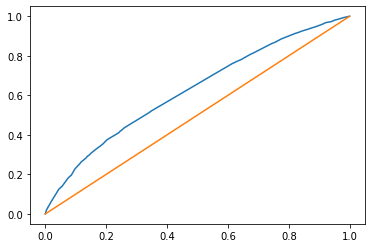

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1, 10), np.linspace(0,1, 10))

In [ ]:
from pyspark.ml.stat import Correlation

In [ ]:
import pandas as pd

In [ ]:
def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=continuous_fields, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)
    

In [ ]:
correlation_matrix(train, continuous_fields)

,Distance,DepHour
Distance,1.000000,-0.013643
DepHour,-0.013643,1.000000


In [ ]:
# correlation_matrix(train, continuous_fields+["DepDelay","Delayed"])

Not bad, considering we have not performed any feature engineering at all!

### Further Reading

https://spark.apache.org/docs/latest/ml-tuning.html

https://stackoverflow.com/questions/28569788/how-to-open-stream-zip-files-through-spark

In [ ]:
# Spark job for the cluster

from pyspark.sql import SparkSession, types, functions
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder


spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(csvname, header= True, inferSchema=True)

# Preprocessing
csvname = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv'
columns_of_interest = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                       'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                       'DepTime', 'DepDelay', 'AirTime', 'Distance']


# Feature extraction
flights = session.read.csv(csvname, header=True, inferSchema=True)
flights = flights.select(columns_of_interest)

flights = flights.na.drop()
flights = flights.withColumn('DepHour', (flights['DepTime'] / 100).cast(types.IntegerType()))
flights = flights.withColumn('Delayed', (flights['DepDelay'] > 15).cast(types.IntegerType()))

# Train/test split
flights_sample, rest = flights.randomSplit([.8, .2])

# Build the Pipeline
categorical_fields = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 
                      'Origin', 'OriginCityName', 'OriginStateName', 
                      'Dest', 'DestCityName', 'DestStateName']

string_fields = [field.name for field in flights_sample.schema.fields if field.dataType == types.StringType()]

continuous_fields = ['Distance', 'DepHour']

target_field = 'Delayed'

indexers = [StringIndexer(inputCol=field, outputCol=field + 'Index', handleInvalid='keep') for field in string_fields]
non_string_categoricals = [field for field in categorical_fields if field not in string_fields]
non_string_categorical_onehotencoders = [OneHotEncoder(inputCol=field, outputCol=field + 'OneHot') for field in non_string_categoricals]
string_categorical_onehotencoders = [OneHotEncoder(inputCol=field+'Index', outputCol=field + 'OneHot') for field in string_fields]

input_cols_onehotencoded = [field + 'OneHot' for field in categorical_fields]

va = VectorAssembler(inputCols= input_cols_onehotencoded + continuous_fields, outputCol='features')

rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='Delayed')

pipeline = Pipeline(stages=indexers + 
                    string_categorical_onehotencoders + 
                    non_string_categorical_onehotencoders + 
                    [va] + 
                    [rf_classifier])

# Tuning and Training
builder = ParamGridBuilder()

our_param_map = builder.addGrid(rf_classifier.maxDepth, [5, 15])\
                       .addGrid(rf_classifier.numTrees, [10, 30])\
                       .build()        

our_evaluator = BinaryClassificationEvaluator(labelCol='Delayed')

split = TrainValidationSplit(estimator=pipeline, 
                             evaluator=our_evaluator, 
                             estimatorParamMaps=our_param_map)

split_model_chosen = split.fit(flights_sample)
predicted = split_model_chosen.transform(rest)
predictions = predicted.select('features',
                               'Delayed',
                               'rawPrediction',
                               'probability',
                               'prediction')

predicted.write.json('out/predicted')
split_model_chosen.bestModel.save('out/split_model_chosen')

In [ ]:
# Check output
predicted_probs = predictions.select('Delayed', 'probability').toPandas()
y_true = predicted_probs['Delayed']
y_prob_predicted = predicted_probs['probability'].map(lambda vector: vector[1])

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_prob_predicted)
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1, 10), np.linspace(0,1, 10))